Erstmal alle Imports klären:

In [ ]:
pip install shapely

In [ ]:
# externe imports
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import glob
import os 
import seaborn as sns

# lokale imports
from utils import euklidean_distance
from config import FPS

# eigene funktionen für dieses notebook
def create_polygon(polygon_coords=list):
    return Polygon(polygon_coords)

def create_point(x, y):
    return Point(x, y)

def is_point_in_polygon(polygon, point):
    return polygon.contains(point)

def interpolate_with_max_gap(df, max_gap=30, method="linear"):
    out = df.copy()
    num_cols = out.select_dtypes(include=[np.number]).columns
    #print(num_cols)

    # 1) Nur „echte“ Interpolation zwischen gültigen Punkten
    out[num_cols] = out[num_cols].interpolate(method=method,
                                              limit_direction="both",
                                              limit_area="inside")
    
    # 2) NaN-Runs > max_gap identifizieren und wieder auf NaN setzen
    for col in num_cols:
        s = df[col]  # Original mit NaNs
        # Gruppen-IDs zwischen Nicht-NaNs erstellen
        grp = s.notna().cumsum()
        # Länge jedes NaN-Runs
        run_len = s.isna().groupby(grp).transform("sum")
        # Maske: Positionen in zu langen NaN-Runs
        too_long = s.isna() & (run_len > max_gap)
        # Zurücksetzen
        out.loc[too_long, col] = np.nan
    
    return out

# variablen 
arena_coords = [(110,20), (1870,25), (1860,1070), (110,1070)]
enter_zone_coords = [(1700,430),(1900,430),(1900,670),(1700,670)]

In [132]:

# ---------- Outlier-Frames finden ----------
def flag_outlier_frames(mean_pairwise_dist: np.ndarray,
                        mean_center_dist: np.ndarray | None = None,
                        pairwise_range: tuple[float, float] | None = (70.0, 150.0),
                        center_range: tuple[float, float] | None = (35.0, 115.0),
                        method: str = "mad", k: float = 3.5, pct=(1, 99),
                        combine: str = "union",   # 'union' (empfohlen) oder 'intersection'
                        min_run_len: int = 1      # z.B. 3, um Einzelframes zu ignorieren
                        ) -> tuple[np.ndarray, dict]:
    """
    Gibt (mask, info) zurück. mask=True → Frame ist Ausreißer.
    - Hybride Logik: Datengetriebene Grenzen ODER harte Bänder → Outlier.
    - combine='union': Outlier wenn pairwise ODER center out-of-range.
      'intersection': nur wenn beide out-of-range.
    """
    n = len(mean_pairwise_dist)
    mp = np.asarray(mean_pairwise_dist, dtype=float)
    mc = None if mean_center_dist is None else np.asarray(mean_center_dist, dtype=float)

    # Outlier-Logik für pairwise
    mask_pair = np.zeros(n, dtype=bool)
    finite_mp = np.isfinite(mp)
    if pairwise_range is not None:
        lo, hi = pairwise_range
        mask_pair |= (mp < lo) | (mp > hi)
    mask_pair &= finite_mp

    # Outlier-Logik für center (falls vorhanden)
    if mc is not None:
        mask_center = np.zeros(n, dtype=bool)
        finite_mc = np.isfinite(mc)
        if center_range is not None:
            lo, hi = center_range
            mask_center |= (mc < lo) | (mc > hi)
        mask_center &= finite_mc
    else:
        mask_center = np.zeros(n, dtype=bool)

    # kombinieren
    if combine == "intersection":
        mask = mask_pair & mask_center
    else:
        mask = mask_pair | mask_center

    info = {
        "mp_bounds_hard": pairwise_range,
        "mc_bounds_hard": center_range,
        "n_flagged": int(mask.sum()),
    }
    return mask, info

# ---------- NaNs in test_df setzen ----------
def apply_outlier_mask_to_df(test_df: pd.DataFrame,
                             scorer: str,
                             individual: str,
                             bodyparts: list[str],
                             mask_outlier: np.ndarray,
                             coords=("x", "y")) -> pd.DataFrame:
    """
    Setzt für geflaggte Frames (mask_outlier=True) die Koordinaten (x,y)
    aller Bodyparts des gegebenen Individuums auf NaN. Inplace.
    """
    assert len(mask_outlier) == len(test_df), "Maskenlänge != Zeilenzahl des DataFrames."
    cols = test_df.loc[:, (scorer, individual, bodyparts, list(coords))].columns
    test_df.loc[mask_outlier, cols] = np.nan
    return test_df

In [5]:
path = r"C:\Users\quicken\Code\Ambros_analysis\code_test"
#path = r"C:\Users\Fabian\Code\Ambros_analysis\code_test"
file_list = glob.glob(os.path.join(path, '*.h5'))

df_list = [pd.read_hdf(f) for f in file_list]

for file in file_list:
    with pd.HDFStore(file, mode='r') as store:
        print(store.keys())


scorer_list = [df.columns.levels[0][0] for df in df_list]
individuals_list = [df.columns.levels[1].to_list() for df in df_list]
bodyparts_list = [df.columns.levels[2].to_list() for df in df_list]

print(file_list)


['/tracks']
['/tracks']
['C:\\Users\\quicken\\Code\\Ambros_analysis\\code_test\\2025_07_09_14_29_58_3_mice_bedding_control_top2_40405188DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280_el.h5', 'C:\\Users\\quicken\\Code\\Ambros_analysis\\code_test\\2025_07_09_14_29_58_3_mice_bedding_control_top2_40405188DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280_el_interpolated_ownfunc.h5']


In [ ]:
# da die h5 verändert werden, wird einmal die ursprüngliche Version gespeichert
for idx, df in enumerate(df_list):
    filename = os.path.basename(file_list[idx])
    filename = filename.rsplit('.')

    # build savepath
    save_as = os.path.join(path, filename[0] + '_old.h5')
    df.to_hdf(save_as, key='tracks')
    


In [89]:
import numpy as np
import pandas as pd
from pathlib import Path
import math

def get_xy_arrays(test_df: pd.DataFrame, scorer: str, individual: str, bodyparts: list[str]):
    """
    Liefert X- und Y-Arrays der Form (n_frames, n_bodyparts) für genau 1 Individuum.
    """
    # X/Y sauber auswählen (unabhängig von Spaltenreihenfolge)
    arr = test_df.loc[:, (scorer, individual, bodyparts, ["x", "y"])].to_numpy()
    arr_x = arr[:, ::2]
    arr_y = arr[:, 1::2]
    return arr_x, arr_y

def mouse_center_and_spread(arr_x: np.ndarray,
                            arr_y: np.ndarray,
                            min_bodyparts: int | None = None) -> dict:
    """
    Berechnet pro Frame:
      - mouse_center_x, mouse_center_y (NaN, wenn zu wenige Punkte)
      - mean_pairwise_dist  = Mittelwert der Distanzen über *alle* Bodypart-Paare
      - mean_center_dist    = Mittelwert der Distanzen jedes Bodyparts zum Center

    NaN-handling:
      - Ein Bodypart ist gültig, wenn X und Y nicht NaN sind.
      - Frames mit < min_bodyparts -> alle Metriken NaN.
    """
    n_frames, n_bp = arr_x.shape
    if min_bodyparts is None:
        min_bodyparts = math.ceil(n_bp / 2)

    valid = (~np.isnan(arr_x)) & (~np.isnan(arr_y))       # (n_frames, n_bp)
    valid_counts = valid.sum(axis=1)                      # (n_frames,)

    # Center (NaN-robust über vorhandene Punkte)
    center_x = np.nanmean(arr_x, axis=1)
    center_y = np.nanmean(arr_y, axis=1)

    # Frames mit zu wenigen Punkten hart auf NaN setzen
    too_few = valid_counts < min_bodyparts
    center_x[too_few] = np.nan
    center_y[too_few] = np.nan

    mean_pairwise = np.full(n_frames, np.nan, dtype=float)
    mean_center   = np.full(n_frames, np.nan, dtype=float)

    # Pro Frame arbeiten (n_bp ist klein → schnell genug & gut lesbar)
    for i in range(n_frames):
        mask = valid[i]
        k = int(mask.sum())
        if k < min_bodyparts:
            continue

        px = arr_x[i, mask]
        py = arr_y[i, mask]

        # --- mittlere Paar-Distanz (über alle Paare) ---
        # Distanzmatrix ohne SciPy: Broadcasting
        dx = px[:, None] - px[None, :]
        dy = py[:, None] - py[None, :]
        dist_mat = np.sqrt(dx * dx + dy * dy)             # (k, k), diag = 0
        # Nur obere Dreiecksmatrix ohne Diagonale mitteln
        triu = np.triu_indices(k, 1)
        pair_vals = dist_mat[triu]
        if pair_vals.size:
            mean_pairwise[i] = pair_vals.mean()

        # --- mittlere Distanz zum Center ---
        cx, cy = center_x[i], center_y[i]
        d_center = np.sqrt((px - cx) ** 2 + (py - cy) ** 2)
        mean_center[i] = d_center.mean()

    return {
        "mouse_center_x": center_x,
        "mouse_center_y": center_y,
        "mean_pairwise_dist": mean_pairwise,
        "mean_center_dist": mean_center,
        "valid_counts": valid_counts,
    }

C:\Users\quicken\AppData\Local\Temp\ipykernel_10552\3368870185.py:37: RuntimeWarning: Mean of empty slice
  center_x = np.nanmean(arr_x, axis=1)
C:\Users\quicken\AppData\Local\Temp\ipykernel_10552\3368870185.py:38: RuntimeWarning: Mean of empty slice
  center_y = np.nanmean(arr_y, axis=1)


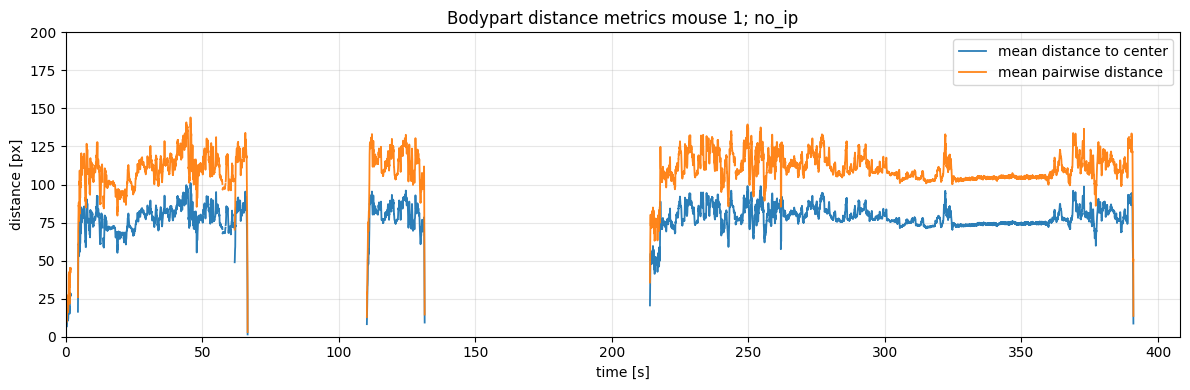

In [164]:
# ausgewählte h5 einlesen, dataframe, scorer, individual und bodypart info extrahieren
path = r"E:\h5_preprocessing\2025_07_09_14_29_58_3_mice_bedding_control_top2_40405188"
test_file_path = r"E:\h5_preprocessing\2025_07_09_14_29_58_3_mice_bedding_control_top2_40405188\2025_07_09_14_29_58_3_mice_bedding_control_top2_40405188DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280_el.h5"
test_df = pd.read_hdf(test_file_path)

# Aus test_df die Ebenen ziehen (achte auf test_df statt df)
scorer     = test_df.columns.levels[0][0]
individuals = list(test_df.columns.levels[1])
bodyparts   = list(test_df.columns.levels[2])

# alte h5 unter 'old' speichern
filename = os.path.basename(test_file_path)
filename = filename.rsplit('.')
save_as = os.path.join(path, filename[0] + '_old.h5')
df.to_hdf(save_as, key='tracks')


filter_via_bodypart_distances = False
if filter_via_bodypart_distances:
    for i in range(len(individuals)):
        # XY holen
        arr_x, arr_y = get_xy_arrays(test_df, scorer, individuals[i], bodyparts)

        # Center + Distanzen berechnen (mind. Hälfte der BPs erforderlich)
        res = mouse_center_and_spread(arr_x, arr_y, min_bodyparts=2)

        # Mouse-Center wie gehabt
        mouse_center = list(zip(res["mouse_center_x"], res["mouse_center_y"]))

        # Zeitreihe der mittleren Paar-Distanz (pro Frame)
        mean_pairwise_dist = res["mean_pairwise_dist"]
        mean_center_dist   = res["mean_center_dist"]

        # filter misstracking via center and bd distances
        mask, info = flag_outlier_frames(
            mean_pairwise_dist,
            mean_center_dist,
            pairwise_range=(70, 150),
            center_range=(35, 115),
            method="mad",   # zusätzlich datengetrieben
            k=3.5,
            combine="union",
            min_run_len=1   # Einzelframes ignorieren (optional)
        )

        print("Geflaggte Frames:", info["n_flagged"])

        # NaNs setzen für ein Individuum
        test_df = apply_outlier_mask_to_df(
            test_df,
            scorer=scorer,
            individual=individuals[i],  # z.B. individual = 0
            bodyparts=bodyparts,
            mask_outlier=mask,
        )

    # Optional: Maske inspizieren/plotten
    #plt.figure(); plt.plot(mask.astype(int)); plt.title("Outlier frames (1=True)")
    filename = os.path.basename(test_file_path)
    filename = filename.rsplit('.')
    save_as = os.path.join(path, filename[0] + '_bp-distance_filtered_and_interpolated.h5')
    test_df.to_hdf(save_as, key='tracks')

# interpolation step
interpolate = False
if interpolate:
    
    #interpolieren
    test_df = interpolate_with_max_gap(test_df, max_gap=30)

    # neue h5 unter 'interpolated_custom' abspeichern
    filename = os.path.basename(test_file_path)
    filename = filename.rsplit('.')
    save_as = os.path.join(path, filename[0] + '_interpolated_custom.h5')
    test_df.to_hdf(save_as, key='tracks')

individual = 0  # 0–2
# XY holen
arr_x, arr_y = get_xy_arrays(test_df, scorer, individuals[individual], bodyparts)

# Center + Distanzen berechnen (mind. Hälfte der BPs erforderlich)
res = mouse_center_and_spread(arr_x, arr_y, min_bodyparts=2)

# Mouse-Center wie gehabt
mouse_center = list(zip(res["mouse_center_x"], res["mouse_center_y"]))

# Zeitreihe der mittleren Paar-Distanz (pro Frame)
mean_pairwise_dist = res["mean_pairwise_dist"]
mean_center_dist   = res["mean_center_dist"]


color_center   = "tab:blue"         # Farbe für mean_center_dist
color_pairwise = "tab:orange"       # Farbe für mean_pairwise_dist

# --- Zeitachse in Sekunden ---
assert len(mean_center_dist) == len(mean_pairwise_dist), "Längen müssen übereinstimmen."
t_sec = np.arange(len(mean_center_dist)) / FPS

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(t_sec, mean_center_dist,   label="mean distance to center",   color=color_center,   lw=1.3, alpha=0.95)
ax.plot(t_sec, mean_pairwise_dist, label="mean pairwise distance",    color=color_pairwise, lw=1.3, alpha=0.95)

# Achsen & Deko
ax.set_title(f"Bodypart distance metrics mouse {str(individual+1)}; {'ip' if interpolate else 'no_ip'}")
ax.set_xlabel("time [s]")
ax.set_ylabel("distance [px]")      # ggf. [mm], falls kalibriert
ax.set_xlim(t_sec[0], t_sec[-1])
ax.set_ylim(0,200)
ax.grid(True, which="both", alpha=0.3)
ax.legend(loc="upper right")

plt.tight_layout()
#plt.savefig(f"{path}\mouse_{str(individual+1)}_{'ip' if interpolate else 'no_ip'}_{'filtered' if filter_via_bodypart_distances else 'unfiltered'}_bodypart_distances.svg")
plt.show()


In [ ]:
test_df

In [ ]:

# ausgewählte h5 einlesen, dataframe, scorer, individual und bodypart info extrahieren
path = r"E:\h5_preprocessing\2025_07_09_14_29_58_3_mice_bedding_control_top2_40405188"
test_file_path = r"E:\h5_preprocessing\2025_07_09_14_29_58_3_mice_bedding_control_top2_40405188\2025_07_09_14_29_58_3_mice_bedding_control_top2_40405188DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280_el.h5"
test_df = pd.read_hdf(test_file_path)
scorer = df.columns.levels[0][0]
individuals = df.columns.levels[1].to_list()
bodyparts = df.columns.levels[2].to_list()

# interpolation step
interpolate = True
if interpolate:
    # alte h5 unter 'old' speichern
    filename = os.path.basename(test_file_path)
    filename = filename.rsplit('.')
    save_as = os.path.join(path, filename[0] + '_old.h5')
    df.to_hdf(save_as, key='tracks')

    #interpolieren
    test_df = interpolate_with_max_gap(test_df, max_gap=30)

    # neue h5 unter 'interpolated_custom' abspeichern
    filename = os.path.basename(test_file_path)
    filename = filename.rsplit('.')
    save_as = os.path.join(path, filename[0] + '_interpolated_custom.h5')
    test_df.to_hdf(save_as, key='tracks')


# individual (0-2)
individual = 0

# erstellt je einen array, der alle x-koordinaten bzw. y-koordinaten arrays einer der individuals enthält
arr_x = test_df.loc[:, (scorer, individuals[individual], bodyparts, ["x", "y"])].values[:,::2]
arr_y = test_df.loc[:, (scorer, individuals[individual], bodyparts, ["x", "y"])].values[:,1::2]

# mean aus allen x bzw allen y Koordinaten um die jeweiligen mouse center points bestimmen zu können
mean_x = np.nanmean(arr_x, axis=1)
mean_y = np.nanmean(arr_y, axis=1)
mouse_center = []
for i in range(len(mean_x)):
    point = (mean_x[i], mean_y[i])
    mouse_center.append(point)



MultiIndex([('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ...
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mer

C:\Users\quicken\AppData\Local\Temp\ipykernel_10552\1122803921.py:36: RuntimeWarning: Mean of empty slice
  mean_x = np.nanmean(arr_x, axis=1)
C:\Users\quicken\AppData\Local\Temp\ipykernel_10552\1122803921.py:37: RuntimeWarning: Mean of empty slice
  mean_y = np.nanmean(arr_y, axis=1)


In [ ]:
"""
# basic interpolation (führt zu anhängungsfehlern)
test_df = test_df.interpolate(
    method="linear",
    limit=30,
    limit_direction="both",     # füllt in beide Richtungen
    limit_area="inside"         # nur zwischen zwei gültigen Punkten
)
"""

C:\Users\quicken\AppData\Local\Temp\ipykernel_10552\2184386410.py:8: RuntimeWarning: Mean of empty slice
  mean_x = np.nanmean(arr_x, axis=1)
C:\Users\quicken\AppData\Local\Temp\ipykernel_10552\2184386410.py:9: RuntimeWarning: Mean of empty slice
  mean_y = np.nanmean(arr_y, axis=1)


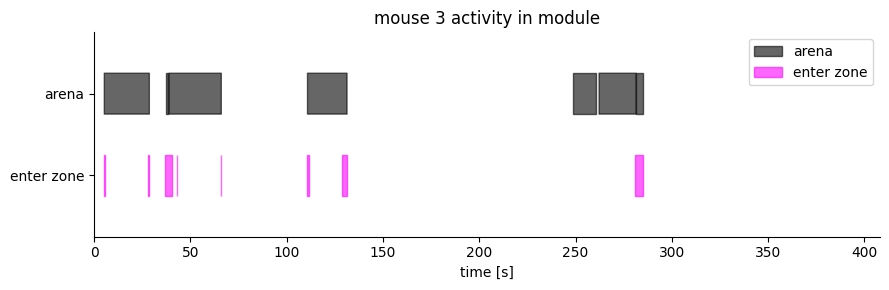

In [162]:
enter_zone_polygon = create_polygon(enter_zone_coords)
arena_polygon = create_polygon(arena_coords)
mouse_in_enter_zone = np.zeros(len(mouse_center))
mouse_in_arena = np.zeros(len(mouse_center))


 # mean aus allen x bzw allen y Koordinaten um die jeweiligen mouse center points bestimmen zu können
mean_x = np.nanmean(arr_x, axis=1)
mean_y = np.nanmean(arr_y, axis=1)
mouse_center = []
for i in range(len(mean_x)):
    point = (mean_x[i], mean_y[i])
    mouse_center.append(point)



# iterates over all frames
for i in range(len(mouse_center)):

    # creats a point out of the mouse center coordinates
    center_point = create_point(mouse_center[i][0], mouse_center[i][1])

    # checks, if mouse center is in enter zone and in arena
    if is_point_in_polygon(polygon=enter_zone_polygon, point=center_point):
        mouse_in_enter_zone[i] = 1
    if is_point_in_polygon(polygon=arena_polygon, point=center_point):
        mouse_in_arena[i] = 1

# Arrays in bool umwandeln (falls sie 0/1 sind)
ez = mouse_in_enter_zone.astype(bool)
ar = mouse_in_arena.astype(bool)


t_sec = np.arange(len(ez)) / FPS  # 0, 1/fps, 2/fps, ...

fig, ax = plt.subplots(figsize=(9, 3))

# Arena (oben)
ax.fill_between(t_sec, 1.5, 2.0, where=ar, color='black', alpha=0.6, label='arena')

# Enter Zone (unten)
ax.fill_between(t_sec, 0.5, 1.0, where=ez, color='magenta', alpha=0.6, label='enter zone')

ax.set_ylim(0, 2.5)
ax.set_xlim(0, len(ez)/FPS)  # jetzt in Sekunden
# Beispiel für Ausschnitt: Frames 6400–6900 → Sekunden:
# ax.set_xlim(6400/fps, 6900/fps)

ax.set_yticks([0.75, 1.75])
ax.set_yticklabels(['enter zone', 'arena'])
ax.set_xlabel("time [s]")
ax.set_title(f"mouse {str(individual+1)} activity in module")
ax.legend(loc='upper right')
sns.despine()

plt.tight_layout()
plt.savefig(f"{path}\mouse_{str(individual+1)}_arena_ez_activity.svg")
plt.show()





In [ ]:
from itertools import combinations
# Manchmal labelled DLC dieselbe Maus doppelt, mit den exakt gleichen Koordinaten von zwei Individuen
# daher möchte ich hier die mittelpunkte der mäuse vergleichen, ob es überschneidungen gibt
mouse_center_x_data = []
mouse_center_y_data = []
for ind in individuals:
    
    arr_x = test_df.loc[:, (scorer, ind, bodyparts, ["x", "y"])].values[:,::2]
    arr_y = test_df.loc[:, (scorer, ind, bodyparts, ["x", "y"])].values[:,1::2]

    mouse_center_x_data.append(np.nanmean(arr_x, axis=1))
    mouse_center_y_data.append(np.nanmean(arr_y, axis=1))

# In ein [Frames × N_mice] Array umwandeln
X = np.column_stack(mouse_center_x_data)  # shape: (n_frames, n_mice)
Y = np.column_stack(mouse_center_y_data)

# Optional: NaNs mit np.nan_to_num oder maske behandeln
# Hier: keine NaN-Füllung, stattdessen NaN-Distanz = inf
nan_mask = np.isnan(X) | np.isnan(Y)

# Alle möglichen Maus-Paare
pairs = list(combinations(range(X.shape[1]), 2))

# Ergebnisse speichern
overlap_frames = {pair: [] for pair in pairs}

# Toleranz in Pixel (0 = exakt gleich)
tol = 0

for frame in range(X.shape[0]):
    for m1, m2 in pairs:
        # Nur prüfen, wenn beide Koordinaten vorhanden sind
        if nan_mask[frame, m1] or nan_mask[frame, m2]:
            continue
        dx = X[frame, m1] - X[frame, m2]
        dy = Y[frame, m1] - Y[frame, m2]
        dist = np.sqrt(dx*dx + dy*dy)
        if dist <= tol:
            overlap_frames[(m1, m2)].append(frame)

# Start- und End-Frames für jede Überlappungssequenz berechnen
overlap_sequences = {}
for pair, frames in overlap_frames.items():
    if not frames:
        continue

    sequences = []
    start = frames[0]
    prev = frames[0]

    for f in frames[1:]:
        if f == prev + 1:  # direkt aufeinanderfolgende Frames
            prev = f
        else:
            sequences.append((start, prev))
            start = f
            prev = f
    sequences.append((start, prev))  # letzte Sequenz hinzufügen

    overlap_sequences[pair] = sequences

# Ausgabe
for pair, seqs in overlap_sequences.items():
    print(f"Mäuse {pair} haben {len(seqs)} Überlappungs-Sequenzen:")
    for s, e in seqs:  
        print(f"  Start: {s}, Ende: {e}, Dauer: {e - s + 1} Frames")

In [16]:
# erstmal alle entries in die enter zone finden
enter_zone_entries = []
for i in range(len(mouse_in_enter_zone)-1):
    if mouse_in_enter_zone[i] == 0 and mouse_in_enter_zone[i+1] == 1:
        enter_zone_entries.append(i) 

# und alle exits aus der enter zone
enter_zone_exits = []
for i in range(len(mouse_in_enter_zone)-1):
    if mouse_in_enter_zone[i] == 1 and mouse_in_enter_zone[i+1] == 0:
        enter_zone_exits.append(i) 

print(enter_zone_entries)
print(enter_zone_exits)

# hier wird versucht alle tatsächlichen modul entries und exits zu finden
modul_entries = []
modul_exits = []
modul_stays = []
modul_entry_exit = []
for idx, frame in enumerate(enter_zone_entries):
    # falls die maus vor dem enter zone entry nicht in der arena war, könnte es sich um einen modul entry handeln
    # ein bereich von einer sekunde wird abgesucht, falls die Maus ggf nicht direkt vor dem eintritt getrackt wurde
    if np.nansum(mouse_in_arena[frame-FPS:frame]) == 0:
        # es handelt sich natürlich nur um einen entry, wenn die maus zum Zeitpunkt des enter zone exits auch in der arena ist, sonst ist sie wieder raus gegangen
        exit_frame = enter_zone_exits[idx]
        # da es in diesem frame auf jeden fall tracking daten gibt (die maus wurde ja in der exit zone getrackt), reicht es hier nur einen frame zu verwenden
        if mouse_in_arena[exit_frame] == 1:
            # es wird erstmal der entry zone entry + entry zone exit als tuple gespeichert, wenn das event zu einem arena entry geführt hat
            modul_entries.append((frame, exit_frame))
        # abspeichern, falls die maus wieder raus gegangen ist
        elif mouse_in_arena[exit_frame] == 0:
            modul_entry_exit.append((frame, exit_frame))

    # falls die maus vorher in der arena war, könnte es sich um einen modul exit handeln        
    elif np.nansum(mouse_in_arena[max(0,frame-FPS):frame]) > 0:
        # das arena polygon und enter zone polygon überlappen teilweise, daher kann es zu mehreren arena entries während dem aufenthalt in der enter zone kommen
        # bei einem exit müsste das letzte arena event ein arena exit sein
        exit_frame = enter_zone_exits[idx]
        was_last_event_exit = False
        mouse_in_arena_during_enter_zone_activity = mouse_in_arena[frame:exit_frame+1]
    
        for i in range(len(mouse_in_arena_during_enter_zone_activity)-1):
            # die arena wird verlassen, in diesem moment ist die letzte arena interaktion ein exit - die flag geht also auf true
            if mouse_in_arena_during_enter_zone_activity[i] == 1 and mouse_in_arena_during_enter_zone_activity[i+1] == 0:
                was_last_event_exit = True
            # die arena wird betreten, also wird die flag wieder auf False gesetzt
            elif mouse_in_arena_during_enter_zone_activity[i] == 0 and mouse_in_arena_during_enter_zone_activity[i+1] == 1:
                was_last_event_exit = False

        if was_last_event_exit:
            modul_exits.append((frame, exit_frame))

        # wenn das letzte event vor dem entry zone exit ein reenrty in die arena war, verbleibt die maus in der arena
        if not was_last_event_exit:
            modul_stays.append((frame, exit_frame))

print(modul_entries)
print(modul_exits)
print(modul_stays)
print(modul_entry_exit)
# 

[156, 1972, 3313, 3861, 8419, 11686]
[161, 1984, 3346, 3941, 8548, 11707]
[(156, 161), (3313, 3346)]
[(1972, 1984), (3861, 3941), (8419, 8548)]
[]
[(11686, 11707)]


In [17]:
# nun können die arena entries und exits mit den vorher bestimmten exits und entries abgeglichen werden, um plötzliches misstracking aufzudecken

# erstmal alle arena entries und exits sammeln
arena_entries = []
arena_exits = []
for i in range(len(mouse_in_arena)-1):
    if mouse_in_arena[i] == 0 and mouse_in_arena[i+1] == 1:
        arena_entries.append(i) 
for i in range(len(mouse_in_arena)-1):
    if mouse_in_arena[i] == 1 and mouse_in_arena[i+1] == 0:
        arena_exits.append(i) 

print(arena_entries)
print(arena_exits)

# schauen ob der arena entry valid ist
# um valid zu sein, darf die arena nur während einem enter zone entry, stay, exit oder entry-exit betreten werden
for entry in arena_entries:
    entry_is_valid = False
    # erst wird mit enter zone entries abgeglichen (sollte die meisten echten rausfiltern)
    for pair in modul_entries:
        if pair[0] <= entry <= pair[1]:
            entry_is_valid = True
    # als nächstes wird mit stays abgeglichen, da hier die maus kurz aus der arena raus und wieder rein dippen kann
    if not entry_is_valid:
        for pair in modul_stays:
            if pair[0] <= entry <= pair[1]:
                entry_is_valid = True
        # dann mit den entry-exit events, falls die maus bis in die arena gedippt ist
        if not entry_is_valid:
            for pair in modul_entry_exit:
                if pair[0] <= entry <= pair[1]:
                    entry_is_valid = True
            # zu guter letzt mit den exit events, falls die maus da nochmal kurz zurück in die arena gedippt ist
            if not entry_is_valid:
                for pair in modul_exits:
                    if pair[0] <= entry <= pair[1]:
                        entry_is_valid = True
    
    print(f"entry {entry} is {entry_is_valid}")


[156, 3322, 7360, 7866, 8446]
[1980, 3939, 7817, 8443, 8546]
entry 156 is True
entry 3322 is True
entry 7360 is False
entry 7866 is False
entry 8446 is True


In [18]:

# Arrays in bool umwandeln (0/1 -> False/True)
ez = mouse_in_enter_zone.astype(bool)
ar = mouse_in_arena.astype(bool)

n = len(ez)

# Hilfsfunktionen/Arrays
prev_ez = np.pad(ez[:-1], (1, 0), constant_values=False)  # enter_zone im Frame i-1
prev_ar = np.pad(ar[:-1], (1, 0), constant_values=False)  # arena im Frame i-1

# Übergänge (mit Padding, damit Länge n bleibt)
ez_enter = np.pad(ez[1:] & ~ez[:-1], (1, 0), constant_values=False)  # 0->1
ez_exit  = np.pad(~ez[1:] & ez[:-1], (1, 0), constant_values=False)  # 1->0
ar_enter = np.pad(ar[1:] & ~ar[:-1], (1, 0), constant_values=False)  # 0->1
ar_exit  = np.pad(~ar[1:] & ar[:-1], (1, 0), constant_values=False)  # 1->0

# Optional: robuster Lookback auf enter_zone (letzte k Frames vor i)
k = 10  # kannst du anpassen oder auf 1 setzen, wenn nur i-1 zählen soll
was_in_ez_recent = np.zeros(n, dtype=bool)
if k > 0:
    # rolling "any" über letzte k Frames vor i (exklusiv i)
    for shift in range(1, k+1):
        was_in_ez_recent |= np.pad(ez[:-shift], (shift, 0), constant_values=False)

# 1) arena_entry: Maus betritt enter_zone, war davor nicht in arena
arena_entry = ez_enter & (~prev_ar)

# 2) arena_exit: Maus verlässt enter_zone, war davor in arena und ist jetzt nicht mehr in arena
#    -> enter_zone 1->0, ar von True -> False
arena_exit = ez_exit & prev_ar & (~ar)

# 3) id_switch (erscheint in arena ohne zuvor in enter_zone gewesen zu sein)
#    -> arena 0->1, und in den letzten k Frames nicht in enter_zone
id_switch_appear = ar_enter & (~was_in_ez_recent)

# 4) id_switch (verlässt arena, ohne dabei enter_zone zu betreten)
#    -> arena 1->0, und aktuell nicht in enter_zone (optional: auch zuletzt nicht)
id_switch_leave = ar_exit & (~ez) & (~was_in_ez_recent)

# Indizes der Events
idx_arena_entry       = np.where(arena_entry)[0]
idx_arena_exit        = np.where(arena_exit)[0]
idx_id_switch_appear  = np.where(id_switch_appear)[0]
idx_id_switch_leave   = np.where(id_switch_leave)[0]

print("arena_entry @", idx_arena_entry)
print("arena_exit  @", idx_arena_exit)
print("id_switch (appear) @", idx_id_switch_appear)
print("id_switch (leave)  @", idx_id_switch_leave)

arena_entry @ [  157  3314 11687]
arena_exit  @ []
id_switch (appear) @ [ 157 7361 7867]
id_switch (leave)  @ [7818]


In [ ]:
print(enter_zone_entries)
print(enter_zone_exits)
print(f"entries: {modul_entries}")
print(f"exits: {modul_exits}")
print(f"stays: {modul_stays}")
print(f"entry & immediate exit: {modul_entry_exit}")

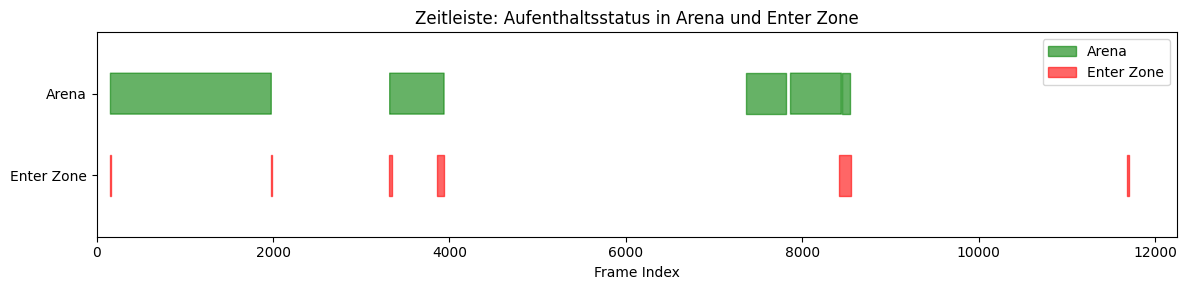

In [19]:
# Arrays in bool umwandeln (falls sie 0/1 sind)
#ez = mouse_in_enter_zone.astype(bool)
#ar = mouse_in_arena.astype(bool)

frames = np.arange(len(ez))

fig, ax = plt.subplots(figsize=(12, 3))

# Arena (grün, oben)
ax.fill_between(frames, 1.5, 2.0, where=ar, color='green', alpha=0.6, label='Arena')

# Enter Zone (rot, unten)
ax.fill_between(frames, 0.5, 1.0, where=ez, color='red', alpha=0.6, label='Enter Zone')

# Achsen formatieren
ax.set_ylim(0, 2.5)
ax.set_xlim(0, len(frames))
#alternative xlim
#ax.set_xlim(6400, 6900)
ax.set_yticks([0.75, 1.75])
ax.set_yticklabels(['Enter Zone', 'Arena'])
ax.set_xlabel("Frame Index")
ax.set_title("Zeitleiste: Aufenthaltsstatus in Arena und Enter Zone")
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

C:\Users\quicken\AppData\Local\Temp\ipykernel_10552\2469290878.py:11: RuntimeWarning: Mean of empty slice
  mean_x = np.nanmean(arr_x, axis=1)
C:\Users\quicken\AppData\Local\Temp\ipykernel_10552\2469290878.py:12: RuntimeWarning: Mean of empty slice
  mean_y = np.nanmean(arr_y, axis=1)


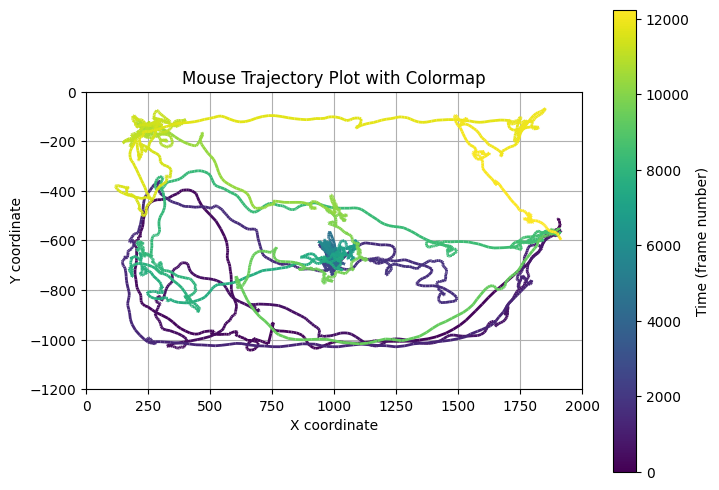

In [12]:
# trajectory plotten
# Plotten mit Colormap

import matplotlib.pyplot as plt
import matplotlib.collections as mc


arr_x = test_df.loc[:, (scorer, individuals[0], bodyparts, ["x", "y"])].values[:,::2]
arr_y = test_df.loc[:, (scorer, individuals[0], bodyparts, ["x", "y"])].values[:,1::2]

mean_x = np.nanmean(arr_x, axis=1)
mean_y = np.nanmean(arr_y, axis=1)

# Beispiel: Ihre Daten (bitte x_coords und y_coords entsprechend setzen)
x_coords = mean_x
y_coords = mean_y *-1

# ggf schneiden
#x_coords = x_coords[2500:4500]
#y_coords = y_coords[2500:4500]



# X- und Y-Koordinaten in Segmente aufteilen
points = np.array([x_coords, y_coords]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Colormap definieren
norm = plt.Normalize(0, len(x_coords))
lc = mc.LineCollection(segments, cmap='viridis', norm=norm)
lc.set_array(np.arange(len(x_coords)))
lc.set_linewidth(2)

# Plot erstellen
fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)
ax.set_xlim(0, 2000.0)
ax.set_ylim(-1200.0, 0)
ax.set_title("Mouse Trajectory Plot with Colormap")
ax.set_xlabel("X coordinate")
ax.set_ylabel("Y coordinate")
ax.grid(True)
ax.set_aspect('equal')

# Colorbar (optional)
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label('Time (frame number)')

plt.savefig(r"C:\Users\quicken\Code\Ambros_analysis\code_test\mouse_1_trajectory.svg")
plt.show()